### Imports

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

### Sample Maps

In [3]:
sample_map = {
    'qqZvvH125': 1,
    'qqWlvH125': 2,
    'Wbb': 3,
    'Wbc': 4,
    'Wcc': 5,
    'Wbl': 6,
    'Wcl': 7,
    'Wl': 8,
    'Zbb': 9,
    'Zbc': 10,
    'Zcc': 11,
    'Zbl': 12,
    'Zcl': 13,
    'Zl': 14,
    'ttbar': 15,
    'stopt': 16,
    'stops': 17,
    'stopWt': 18,
    'WW': 19,
    'ZZ': 20,
    'WZ': 21
}
sample_map_invert = dict(zip(sample_map.values(),sample_map.keys()))


reduce_map = {
    'qqZvvH125': 'VH',
    'qqWlvH125': 'VH',
    'Wbb': 'V+jets',
    'Wbc': 'V+jets',
    'Wcc': 'V+jets',
    'Wbl': 'V+jets',
    'Wcl': 'V+jets',
    'Wl': 'V+jets',
    'Zbb': 'V+jets',
    'Zbc': 'V+jets',
    'Zcc': 'V+jets',
    'Zbl': 'V+jets',
    'Zcl': 'V+jets',
    'Zl': 'V+jets',
    'ttbar': 'ttbar',
    'stopt': 'stop',
    'stops': 'stop',
    'stopWt': 'stop',
    'WW': 'diboson',
    'ZZ': 'diboson',
    'WZ': 'diboson'
}

reduced_sample_map = dict()

signal_zipped = dict(zip(range(1, 3), ['VH' for x in range(2)]))
Vjets_zipped = dict(zip(range(3, 15), ['V+jets' for x in range(12)]))
ttbar_zipped = {15: 'ttbar'}
stop_zipped = dict(zip(range(16, 19), ['stop' for x in range(3)]))
diboson_zipped = dict(zip(range(19, 22), ['diboson' for x in range(3)]))

reduced_sample_map.update(signal_zipped)
reduced_sample_map.update(Vjets_zipped)
reduced_sample_map.update(ttbar_zipped)
reduced_sample_map.update(stop_zipped)
reduced_sample_map.update(diboson_zipped)

branch_names = ["sample", "EventWeight", "EventNumber", "nJ", "nBJ", "mBB",
                "dRBB", "dPhiBB", "dEtaBB",
                "dPhiVBB", "dPhiLBmin", "Mtop", "dYWH", "dEtaWH",
                "dPhiLMET", "pTV", "pTB1", "pTB2", "pTL", "etaL",
                "mTW", "MET", "pTJ3", "mBBJ", "BDT"]

In [4]:
# %load ~/dev/root_dev/skl_analysis/scale_factors.py
SF_map_2jet = {
	'Zl': 1.0,
	'Zcl': 1.41,
	'Zcc': 1.15,
	'Zbl': 1.15,
	'Zbc': 1.15,
	'Zbb': 1.15,
	'Wl': 1.00,
	'Wcl': 1.22,
	'Wcc': 1.65,
	'Wbl': 1.65,
	'Wbc': 1.65,
	'Wbb': 1.65,
	'stopWt': 0.92,
	'stopt': 0.92,
	'stops': 0.92,
	'ttbar': 0.80,
	'multijet': 0.63,
	'WW': 1.13,
	'ZZ': 1.13,
	'WZ': 1.13,
	'qqZvvH125': 0.20,
	'qqWlvH125': 0.20
}

### Data Handling

In [5]:
# Read in NTuple data from pre-processed CSV file.
df = pd.read_csv('/Volumes/THUMB/VHbb-data/CSV/VHbb_data_preselect.csv', index_col=0)

# Split into 2 jet and 3 jet trainings.
df_2jet = df[df['nJ'] == 2]
df_3jet = df[df['nJ'] == 3]

# Classification array for these DFs.
classification_2jet = df_2jet['Class'].as_matrix()
classification_3jet = df_3jet['Class'].as_matrix()

# Drop unneeded columns for the training.
df_2jet_filtered = df_2jet.drop(['sample','EventWeight','nJ','nBJ', 'dEtaBB', 'dPhiBB',
                                 'dEtaWH', 'dPhiLMET', 'BDT', 'pTL', 'etaL', 'Class',
                                 'mBBJ', 'pTJ3'], axis=1)
df_3jet_filtered = df_3jet.drop(['sample','EventWeight','nJ','nBJ', 'dEtaBB', 'dPhiBB',
                                 'dEtaWH', 'dPhiLMET', 'BDT', 'pTL', 'etaL', 'Class'], axis=1)

# Convert to ndarray. All elements will be recast as floats.
dataset_2jet = df_2jet_filtered.as_matrix()
dataset_3jet = df_3jet_filtered.as_matrix()

# Split into training and test sets.
X_k1_2jet, X_k2_2jet, Y_k1_2jet, Y_k2_2jet = train_test_split(dataset_2jet,
                                                                            classification_2jet,
                                                                            test_size=0.5,
                                                                            random_state=42)

X_k1_3jet, X_k2_3jet, Y_k1_3jet, Y_k2_3jet = train_test_split(dataset_3jet,
                                                                            classification_3jet,
                                                                            test_size=0.5,
                                                                            random_state=42)

# Preserve event numbers of train and test sets, then drop from training and test sets.

X_k1_2jet_event_nos = X_k1_2jet[:, 0].astype(int)
X_k1_3jet_event_nos = X_k1_3jet[:, 0].astype(int)
X_k2_2jet_event_nos = X_k2_2jet[:, 0].astype(int)
X_k2_3jet_event_nos = X_k2_3jet[:, 0].astype(int)

X_k1_2jet = np.delete(X_k1_2jet, 0, 1)
X_k1_3jet = np.delete(X_k1_3jet, 0, 1)
X_k2_2jet = np.delete(X_k2_2jet, 0, 1)
X_k2_3jet = np.delete(X_k2_3jet, 0, 1)

# Map event numbers to process type numbers.
event_to_process_nos = pd.Series(df['sample'].as_matrix(),
                                 index=df['EventNumber'].as_matrix()).to_dict()

X_k1_2jet_process_nos = map(lambda a: event_to_process_nos[a],X_k1_2jet_event_nos)
X_k1_3jet_process_nos = map(lambda a: event_to_process_nos[a],X_k1_3jet_event_nos)
X_k2_2jet_process_nos = map(lambda a: event_to_process_nos[a],X_k2_2jet_event_nos)
X_k2_3jet_process_nos = map(lambda a: event_to_process_nos[a],X_k2_3jet_event_nos)

# Map process types numbers to process type groups.
# Note that this is a convoluted process and could be
# simplified at a later date...
X_k1_2jet_processes = np.array(map(lambda a: sample_map_invert[a], X_k1_2jet_process_nos))
X_k1_3jet_processes = np.array(map(lambda a: sample_map_invert[a], X_k1_3jet_process_nos))
X_k2_2jet_processes = np.array(map(lambda a: sample_map_invert[a], X_k2_2jet_process_nos))
X_k2_3jet_processes = np.array(map(lambda a: sample_map_invert[a], X_k2_3jet_process_nos))

X_2jet_processes = np.append(X_k1_2jet_processes, X_k2_2jet_processes)

# Get event to weight mapping.
event_to_weight = pd.Series(df['EventWeight'].as_matrix(),
                            index=df['EventNumber'].as_matrix()).to_dict()

# Map event numbers to event weights.
weights_k1_2jet = np.array(map(lambda a: event_to_weight[a], X_k1_2jet_event_nos))
weights_k1_3jet = np.array(map(lambda a: event_to_weight[a], X_k1_3jet_event_nos))
weights_k2_2jet = np.array(map(lambda a: event_to_weight[a], X_k2_2jet_event_nos))
weights_k2_3jet = np.array(map(lambda a: event_to_weight[a], X_k2_3jet_event_nos))

weights_2jet = np.append(weights_k1_2jet, weights_k2_2jet)
weights_3jet = np.append(weights_k1_3jet, weights_k2_3jet)

### 2 Jet BDTs

In [9]:
bdt_k1_2jet = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3, min_samples_split=0.05),
                         learning_rate=0.15,
                         algorithm="SAMME",
                         n_estimators=200
                         )

bdt_k2_2jet = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3, min_samples_split=0.05),
                         learning_rate=0.15,
                         algorithm="SAMME",
                         n_estimators=200
                         )

# Train BDT for 2 jet.
bdt_k1_2jet.fit(X_k1_2jet, Y_k1_2jet, sample_weight=weights_k1_2jet)
bdt_k2_2jet.fit(X_k2_2jet, Y_k2_2jet, sample_weight=weights_k2_2jet)

# Get decision scores.
# K1 BDT tests on K2 data, and vice-versa.
output_k1_2jet = np.array(bdt_k1_2jet.decision_function(X_k2_2jet))
output_k2_2jet = np.array(bdt_k2_2jet.decision_function(X_k1_2jet))
output_2jet = np.append(output_k1_2jet, output_k2_2jet)

### Hyperparameter Scan

In [10]:
param_grid = {"n_estimators": np.arange(100,350,50),
              "learning_rate": np.arange(0.1,0.4,0.1),
              "base_estimator__splitter": ['best', 'random']}


def hyperparam_scan(mva, param_grid, X, Y):
    
    scanner = GridSearchCV(mva,
                           param_grid,
                           scoring='roc_auc',
                           n_jobs=1,
                           cv=3)
    
    scanner.fit(X,Y)
    return scanner

### 2 Jet Plot

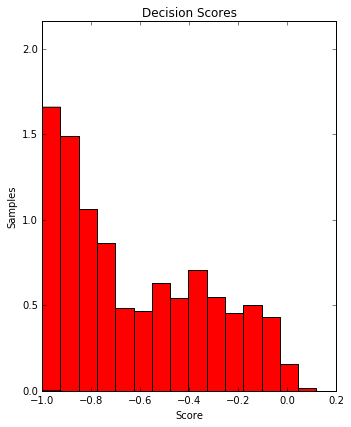

In [21]:
# Plot decision histogram.
plot_range = (output_2jet.min(), output_2jet.max())
plt.subplot(122)

plot_colors = 2*"r" + 12*"g" + "y" + 3*"b" + 3*"m"
plot_step = 0.02
class_names = ['qqZvvH125', 'qqWlvH125', 'Wbb', 'Wbc', 'Wcc', 'Wbl', 'Wcl', 'Wl',
               'Zbb', 'Zbc', 'Zcc', 'Zbl', 'Zcl', 'Zl', 'ttbar', 'stopt', 'stops',
               'stopWt', 'WW', 'ZZ', 'WZ']

for n, c in zip(class_names[:2], plot_colors[:2]):
    this_data = output_2jet[X_2jet_processes == n]
    this_weights = weights_2jet[X_2jet_processes == n] * SF_map_2jet[n]
    plt.hist(this_data,
             bins=15,
             weights=this_weights,
             range=plot_range,
             facecolor=c,
             label='%s' % n,
             stacked=True)
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, y1, y2 * 1.2))
# plt.legend(loc='upper right')
plt.ylabel('Samples')
plt.xlabel('Score')
plt.title('Decision Scores')

plt.tight_layout()
plt.subplots_adjust(wspace=0.35)
plt.show()

In [12]:
len(weights_2jet)

38745